# Кейс №6

## Прогнозирование исходов заболевания циррозом печени с помощью ML

## Участники:

- Алёна Лозинская
- Валентина Кулакова
- Дмитрий Волобуев
- Артур Григорян
- Ильсия Коткова
- Матвей Радаев

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import optuna
import shap

In [2]:
plt.style.use("default")
sns.set_palette("Set2")

RANDOM_STATE = 42
TARGET_COL = "Status"
DROP_COL = ["id", "N_Days"]

# Этап I. Предобработка данных для ML

Загрузим данные, разделим наши признаки на числовые и категориальные, преобразуем таргет в бинарный, разделим на train и test.

In [3]:
df = pd.read_csv("../../data/train.csv").drop(columns=DROP_COL)

In [4]:
target_maps = {"C": 0, "D": 1}

binary_maps = {
    "Drug": {"Placebo": 0, "D-penicillamine": 1},
    "Sex": {"F": 0, "M": 1},
    "Ascites": {"N": 0, "Y": 1},
    "Hepatomegaly": {"N": 0, "Y": 1},
    "Spiders": {"N": 0, "Y": 1}
}

binary_features = list(binary_maps.keys())
multi_category_features = ["Edema", "Stage"]

numeric_features = ["Age", "Bilirubin", "Cholesterol", "Albumin", "Copper",
                    "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

Исходный таргет с тремя категориями преобразуем в две и будем решать задачу бинарной классификации.

Класс CL означает, что пациент выжил благодаря трансплантации печени. А информации о том, кому была сделана или назначена трансплантация, в данных нет. Поэтому мы не можем корректно предсказать событие CL по исходным биохимическим показателям - оно зависит не только от тяжести болезни, но и от внешних факторов (решение врача, наличие органа, успешность операции). Среди представителей класса D также могли быть пациенты, которые перенесли трансплантацию печени, равно как и в классе C могут быть пациенты, которым предстоит операция, но мы об этом не знаем. Кроме того, CL очень малочисленный: всего 3.5% против 33.7% и 62.8% классов D и C соответственно. Поэтому его разумно исключить и решать задачу в виде бинарной классификации:

- Класс 0, умеренная стадия заболевания — C (пациент жив)
- Класс 1, тяжёлая стадия заболевания — D (летальный исход)

In [5]:
df = df[df[TARGET_COL] != 'CL'].reset_index(drop=True)

df[TARGET_COL] = df[TARGET_COL].map(target_maps)

df[TARGET_COL].value_counts(normalize=True)

Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64

Разделим все данные на train и test. Подбор методов обработки признаков, настройку гиперпараметров и оценку качества будем проводить только на кросс-валидации на train. Test служит для финальной оценки качества лучшей модели.

In [6]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

In [7]:
print("Распределение таргета на train:")
print(y_train.value_counts(normalize=True))

print("=="*25)

print("Распределение таргета на test:")
print(y_test.value_counts(normalize=True))

Распределение таргета на train:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64
Распределение таргета на test:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64


Числовые признаки оставим в исходном виде, поскольку ML-модели на основе деревьев не накладывают жёстких требований в виде масштабирования, коррекции асимметрии и борьбы с выбросами. Поэтому в качестве обработки признаков закодируем только категориальные фичи:

- бинарные как 0 и 1
- Edema и Stage через OrdinalEncoder

In [8]:
class BinaryMapper(BaseEstimator, TransformerMixin):
    """
    Превращает бинарные категориальные в 0/1 по заданному словарю.
    """
    def __init__(self, mapping: dict):
        self.mapping = mapping
        self.columns_ = list(mapping.keys())

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.columns_)
        for col, mapping in self.mapping.items():
            X_df[col] = X_df[col].map(mapping)
        return X_df

    def get_feature_names_out(self, input_features=None):
        return self.columns_

In [9]:
processor = ColumnTransformer(
    transformers=[
        ("binary", BinaryMapper(binary_maps), binary_features),
        ("category", OrdinalEncoder(), multi_category_features)
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

Будем использовать StratifiedKFold, чтобы в каждом фолде была соблюдена пропорция классов. Установим 5 фолдов.

In [10]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Этап II. Обучение модели Random Forest

Напишем вспомогательные функции для создания общего пайплайна и подбора гиперпараметров (включая методы сэмплирования для борьбы с дисбалансом классов) через optuna. В функции с созданием пайплайнов можно передавать базовый processor для категориальных переменных, а также флаг use_fe - значение True позволяет добавить в предобработку дополнительные шаги в случае feature engineering.

In [11]:
def make_rf_pipeline(trial, preprocessor=processor, use_fe=False):

    sampler_name = trial.suggest_categorical("sampler", ["passthrough", "under", "over", "smote"])
    if sampler_name == "passthrough":
        sampler = "passthrough"
    elif sampler_name == "under":
        sampler = RandomUnderSampler(random_state=RANDOM_STATE)
    elif sampler_name == "over":
        sampler = RandomOverSampler(random_state=RANDOM_STATE)
    else:
        k_neighbors = trial.suggest_int("smote_k_neighbors", 3, 10)
        sampler = SMOTE(random_state=RANDOM_STATE, k_neighbors=k_neighbors)

    rf = RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        n_estimators=trial.suggest_int("rf_n_estimators", 50, 800),
        max_depth=trial.suggest_categorical("rf_max_depth", [3, 5, 7, 10, 15, 20, None]),
        min_samples_split=trial.suggest_int("rf_min_samples_split", 2, 20),
        min_samples_leaf=trial.suggest_int("rf_min_samples_leaf", 1, 20),
        max_features=trial.suggest_categorical("rf_max_features", [None, "sqrt", "log2"]),
        class_weight=trial.suggest_categorical("rf_class_weight", [None, "balanced", "balanced_subsample"]),
        bootstrap=True,
        max_samples=trial.suggest_float("rf_max_samples", 0.5, 1.0),
    )
    
    if not use_fe:
        return ImbPipeline([
            ("preprocess", processor),
            ("sampler", sampler),
            ("rf", rf)
        ])
    
    return ImbPipeline([
        ("symptom_score", SymptomScoreTransformer()),
        ("bilirubin_albumin_ratio", BilirubinAlbuminRatioTransformer()),
        ("coagulation_index", CoagulationIndexTransformer()),
        ("enzyme_pattern", EnzymePatternTransformer()),
        ("preprocess", processor),
        ("sampler", sampler),
        ("rf", rf)
    ])


def optuna_cv_search(make_pipeline_fn, X, y, cv, n_trials=50, scoring="recall", random_state=RANDOM_STATE):

    def objective(trial):
        pipeline = make_pipeline_fn(trial)
        scores = cross_val_score(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
        return float(np.mean(scores))

    sampler = optuna.samplers.TPESampler(seed=random_state)
    study = optuna.create_study(direction="maximize", sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
    return study


def create_best_pipeline(study, processor=processor, use_fe=False):

    best_params = study.best_trial.params

    if best_params["sampler"] == "passthrough":
        best_sampler = "passthrough"
    elif best_params["sampler"] == "under":
        best_sampler = RandomUnderSampler(random_state=RANDOM_STATE)
    elif best_params["sampler"] == "over":
        best_sampler = RandomOverSampler(random_state=RANDOM_STATE)
    else:
        best_sampler = SMOTE(
            random_state=RANDOM_STATE,
            k_neighbors=best_params.get("smote_k_neighbors", 5)
        )

    rf = RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        n_estimators=best_params["rf_n_estimators"],
        max_depth=best_params["rf_max_depth"],
        min_samples_split=best_params["rf_min_samples_split"],
        min_samples_leaf=best_params["rf_min_samples_leaf"],
        max_features=best_params["rf_max_features"],
        class_weight=best_params["rf_class_weight"],
        bootstrap=True,
        max_samples=best_params["rf_max_samples"],
    )

    if not use_fe:
        return ImbPipeline([
            ("preprocess", processor),
            ("sampler", best_sampler),
            ("rf", rf),
        ])

    return ImbPipeline([
        ("symptom_score", SymptomScoreTransformer()),
        ("bilirubin_albumin_ratio", BilirubinAlbuminRatioTransformer()),
        ("coagulation_index", CoagulationIndexTransformer()),
        ("enzyme_pattern", EnzymePatternTransformer()),
        ("preprocess", processor),
        ("sampler", best_sampler),
        ("rf", rf),
    ])

Напишем вспомогательные функции для визуализаций

In [12]:
# барплот важности признаков
def plot_feature_importances(estimator, model_step_name="rf", top_n=None, title="Важность признаков"):

    if hasattr(estimator, "best_estimator_"):
        pipe = estimator.best_estimator_
    else:
        pipe = estimator

    model = pipe.named_steps[model_step_name]
    preprocess = pipe.named_steps["preprocess"]

    feature_names = preprocess.get_feature_names_out()
    importances = model.feature_importances_

    df_imp = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)

    if top_n is not None:
        df_imp = df_imp.head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_imp, y="feature", x="importance")
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")
    plt.title(title)
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

    return df_imp


# кривые precision, recall, F1 в зависимости от порога
def plot_threshold_curves(estimator, X, y, cv, title="Зависимость метрик от порога"):

    if hasattr(estimator, "best_estimator_"):
        model = estimator.best_estimator_
    else:
        model = estimator

    y_proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]

    thresholds = np.arange(0.1, 0.91, 0.05)
    recalls, precisions, f1s = [], [], []

    for thr in thresholds:
        y_thr = (y_proba >= thr).astype(int)
        recalls.append(recall_score(y, y_thr))
        precisions.append(precision_score(y, y_thr))
        f1s.append(f1_score(y, y_thr))

    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, recalls, label="Recall")
    plt.plot(thresholds, precisions, label="Precision")
    plt.plot(thresholds, f1s, label="F1")
    plt.xlabel("Порог вероятности")
    plt.ylabel("Метрика")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.title(title)
    plt.tight_layout()
    plt.show()


# матрица ошибок
def plot_confusion_matrix_simple(y_true, y_pred, title="Матрица ошибок"):
    
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()
    

# визуализация важности признаков по версии SHAP
def plot_shap(pipeline, X):
    
    preprocessor = pipeline[:-2]
    model = pipeline.named_steps['rf']
    
    X_transformed = preprocessor.transform(X)
    X_transformed = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_transformed)

    shap_values_positive = shap_values[:, :, 1]
    shap.initjs()
    shap.summary_plot(shap_values_positive, X_transformed)

    plt.tight_layout()
    plt.show()

## 1. RF

Подбираем гиперпараметры

In [ ]:
study_rf = optuna_cv_search(lambda t: make_rf_pipeline(t, processor, use_fe=False),
                            X_train,
                            y_train,
                            cv=skf,
                            n_trials=300,
                            scoring="recall"
                           )

In [14]:
print("RF best pipeline:")
print(f"Best params: {study_rf.best_trial.params}")
print(f"Best recall: {study_rf.best_value:.4f}")

RF best pipeline:
Best params: {'sampler': 'under', 'rf_n_estimators': 473, 'rf_max_depth': 20, 'rf_min_samples_split': 7, 'rf_min_samples_leaf': 1, 'rf_max_features': 'sqrt', 'rf_class_weight': 'balanced_subsample', 'rf_max_samples': 0.6095011330566877}
Best recall: 0.8279


In [15]:
best_pipeline = create_best_pipeline(study_rf, processor, use_fe=False)

y_pred = cross_val_predict(best_pipeline, X_train, y_train, cv=skf, n_jobs=-1) 

print("RF best estimator:")
print(classification_report(y_train, y_pred))

RF best estimator:
              precision    recall  f1-score   support

           0       0.90      0.84      0.87      3972
           1       0.73      0.83      0.78      2132

    accuracy                           0.83      6104
   macro avg       0.82      0.83      0.82      6104
weighted avg       0.84      0.83      0.84      6104



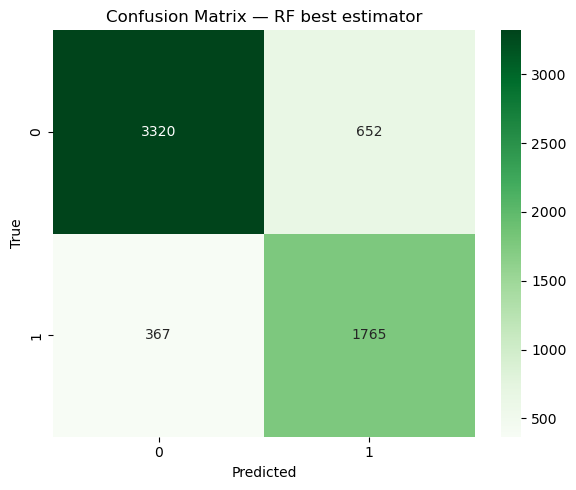

In [16]:
plot_confusion_matrix_simple(y_train, y_pred, title="Confusion Matrix — RF best estimator")

Наилучшее качество по ключевой метрике (recall) демонстрирует модель Random Forest, использующая RandomUnderSampler как метод борьбы с дисбалансом классов:

- recall - 0.83
- precision - 0.73

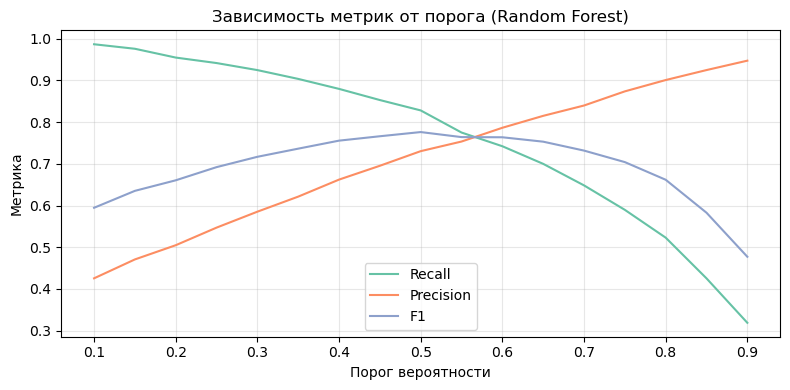

In [17]:
plot_threshold_curves(best_pipeline, X_train, y_train, cv=skf,
                      title="Зависимость метрик от порога (Random Forest)")

При этом видим, что с помощью изменения порога можно поднять recall, пропорционально потеряв в precision

In [18]:
THRESHOLD = 0.35

y_proba = cross_val_predict(best_pipeline, X_train, y_train, method="predict_proba", cv=skf, n_jobs=-1)[:, 1]
y_pred_thr = (y_proba >= THRESHOLD).astype(int)

print(f"Отчёт по классам (порог {THRESHOLD}):")
print(classification_report(y_train, y_pred_thr))

Отчёт по классам (порог 0.35):
              precision    recall  f1-score   support

           0       0.93      0.70      0.80      3972
           1       0.62      0.90      0.74      2132

    accuracy                           0.77      6104
   macro avg       0.78      0.80      0.77      6104
weighted avg       0.82      0.77      0.78      6104



## 2. RF + Feature Engineering

Попробуем добавить кастомные фичи в признаковое пространство и заново подобрать гиперпараметры

In [19]:
class SymptomScoreTransformer(BaseEstimator, TransformerMixin):
    """
    Symptom_Score - суммарное кол-во осложнений (Ascites, Hepatomegaly, Spiders, Edema)
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        mapping = {'N': 0, 'Y': 1, 'S': 1}

        ascites = X['Ascites'].map(mapping)
        hepatomegaly = X['Hepatomegaly'].map(mapping)
        spiders = X['Spiders'].map(mapping)
        edema = X['Edema'].map(mapping)

        X['Symptom_Score'] = ascites + hepatomegaly + spiders + edema
        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        input_features = list(input_features)
        return np.array(input_features + ["Symptom_Score"], dtype=object)


class BilirubinAlbuminRatioTransformer(BaseEstimator, TransformerMixin):
    """
    Bilirubin_Albumin_Ratio = Bilirubin / Albumin
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Bilirubin_Albumin_Ratio'] = X['Bilirubin'] / (X['Albumin'] + eps)
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Bilirubin_Albumin_Ratio"], dtype=object)
    

class CoagulationIndexTransformer(BaseEstimator, TransformerMixin):
    """
    Coagulation_Index = Prothrombin / Albumin (показатель синтетической функции печени)*
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Coagulation_Index'] = X['Prothrombin'] / (X['Albumin'] + eps)
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Coagulation_Index"], dtype=object)
    

class EnzymePatternTransformer(BaseEstimator, TransformerMixin):
    """
    Добавляет Enzyme_Pattern = SGOT / Alk_Phos (тип поражения печени)*
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Enzyme_Pattern'] = X['SGOT'] / (X['Alk_Phos'] + eps)
        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Enzyme_Pattern"], dtype=object)

* CoagulationIndex — это отношение протромбина к альбумину. Оно отражает синтетическую функцию печени: при тяжёлом циррозе протромбиновое время растёт, а альбумин падает. Поэтому высокий индекс означает выраженную печёночную недостаточность и высокий риск неблагоприятного исхода. Эти параметры входят в шкалу Child-Pugh.

* Enzyme_Pattern — соотношение SGOT и щелочной фосфатазы отражает так называемый ферментный паттерн. Высокое значение указывает на гепатоцеллюлярное повреждение (клеточное воспаление), а низкое — на холестаз. В циррозе преобладание холестаза часто связано с более тяжёлым течением, поэтому этот индекс помогает дереву улавливать тип поражения печени.

In [ ]:
study_rf_fe = optuna_cv_search(lambda t: make_rf_pipeline(t, processor, use_fe=True),
                               X_train,
                               y_train,
                               cv=skf,
                               n_trials=300,
                               scoring="recall"
                              )

In [21]:
print("Best pipeline (RF + FE):")
print(f"Best params: {study_rf_fe.best_trial.params}")
print(f"Best recall: {study_rf_fe.best_value:.4f}")

Best pipeline (RF + FE):
Best params: {'sampler': 'under', 'rf_n_estimators': 245, 'rf_max_depth': 20, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 1, 'rf_max_features': 'log2', 'rf_class_weight': 'balanced', 'rf_max_samples': 0.7722227026480597}
Best recall: 0.8227


In [22]:
best_pipeline_fe = create_best_pipeline(study_rf_fe, processor, use_fe=True)

y_pred_fe = cross_val_predict(best_pipeline_fe, X_train, y_train, cv=skf, n_jobs=-1) 

print("RF + FE best estimator:")
print(classification_report(y_train, y_pred_fe))

RF + FE best estimator:
              precision    recall  f1-score   support

           0       0.90      0.83      0.86      3972
           1       0.73      0.82      0.77      2132

    accuracy                           0.83      6104
   macro avg       0.81      0.83      0.82      6104
weighted avg       0.84      0.83      0.83      6104



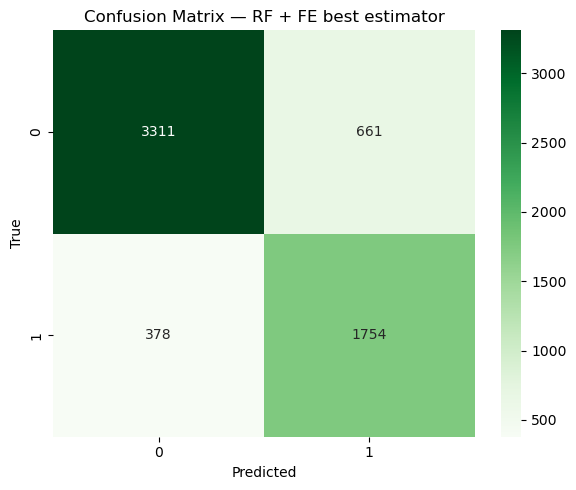

In [23]:
plot_confusion_matrix_simple(y_train, y_pred_fe,
                             title="Confusion Matrix — RF + FE best estimator")

Модель с дополнительными признаками показала качество ниже: по матрице ошибок видно, что мы незначительно потеряли и в precision, и в recall. В качестве финальной версии будем использовать пайплайн без дополнительных признаков.

# Этап III. Оценка Feature Importance

Обучим лучший пайплайн на полном train и оценим важность признаков по версиям RF и SHAP

In [24]:
final_pipeline = create_best_pipeline(study_rf, processor, use_fe=False)

In [25]:
final_pipeline.fit(X_train, y_train)

C:\Users\dmitry.volobuev_inde\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary',
                                                  BinaryMapper(mapping={'Ascites': {'N': 0,
                                                                                    'Y': 1},
                                                                        'Drug': {'D-penicillamine': 1,
                                                                                 'Placebo': 0},
                                                                        'Hepatomegaly': {'N': 0,
                                                                                         'Y': 1},
                                                                        'Sex': {'F': 0,
                                                                                'M': 1},
                                                                        'Spiders': {'N': 0,
                                                                                    'Y': 1}}),
                                                  ['Drug', 'Sex', 'Ascites',
                                                   'Hepatomegaly', 'Spiders']),
                                                 ('category', OrdinalEncoder(),
                                                  ['Edema', 'Stage'])],
                                   verbose_feature_names_out=False)),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('rf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        max_depth=20,
                                        max_samples=0.6095011330566877,
                                        min_samples_split=7, n_estimators=473,
                                        n_jobs=-1, random_state=42))])

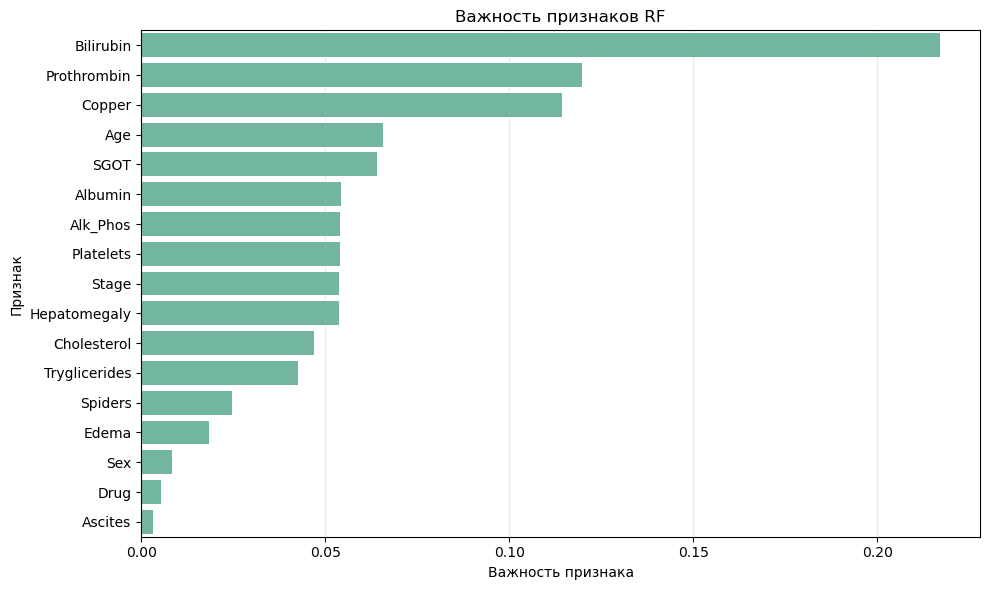

,feature,importance
8,Bilirubin,0.217042
16,Prothrombin,0.119734
11,Copper,0.114322
7,Age,0.065778
13,SGOT,0.064076
10,Albumin,0.054245
12,Alk_Phos,0.053955
15,Platelets,0.053910
6,Stage,0.053782
3,Hepatomegaly,0.053589


In [27]:
plot_feature_importances(final_pipeline, title="Важность признаков RF")

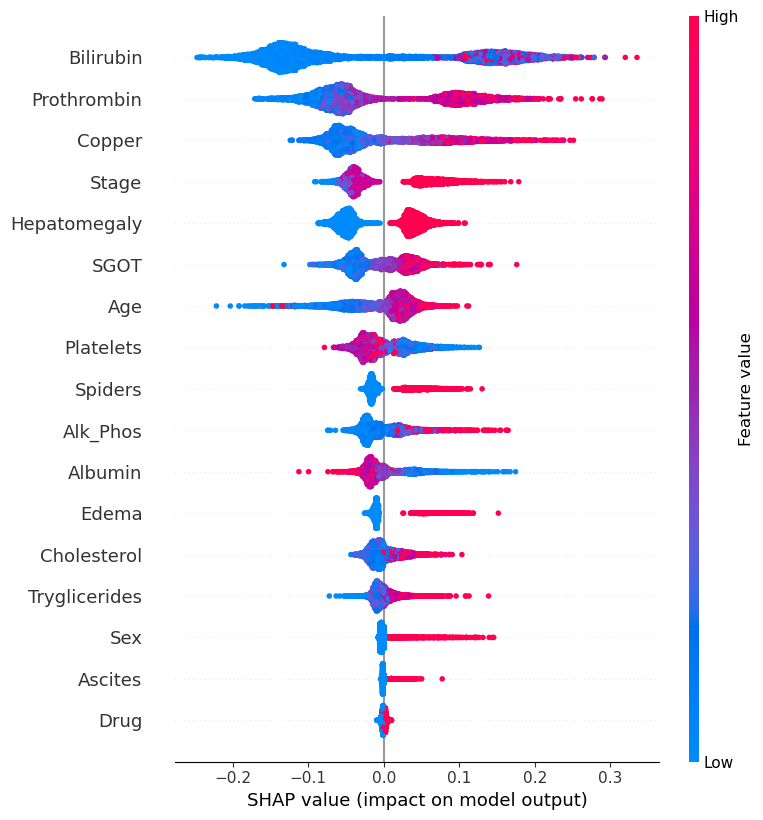

<Figure size 640x480 with 0 Axes>

In [28]:
plot_shap(final_pipeline, X_train)

По SHAP-графику видно, что наиболее важными признаками для модели являются биохимические показатели: Bilirubin, Prothrombin и Copper. Точки красного цвета (высокие значения признака) у Bilirubin, Prothrombin и Copper в основном находятся справа, то есть большие значения этих показателей обычно увеличивают вероятность неблагоприятного исхода (класс 1). Для Platelets и Albumin картина обратная: низкие значения чаще связаны с неблагоприятным течением болезни. Среди категориальных признаков наибольший вклад вносят Stage и Hepatomegaly. Остальные признаки (например, Cholesterol, Tryglicerides, Sex, Ascites, Drug) влияют заметно слабее - их точки в основном сгруппированы ближе к нулю.

# IV. Проверка на тесте

In [29]:
THRESHOLD = 0.35

y_proba_test = final_pipeline.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= THRESHOLD).astype(int)

In [30]:
print(f"Test RF best estimator (threshold={THRESHOLD}):")
print(classification_report(y_test, y_pred_test))

Test RF best estimator (threshold=0.35):
              precision    recall  f1-score   support

           0       0.93      0.68      0.78       993
           1       0.60      0.91      0.72       533

    accuracy                           0.76      1526
   macro avg       0.77      0.79      0.75      1526
weighted avg       0.82      0.76      0.76      1526



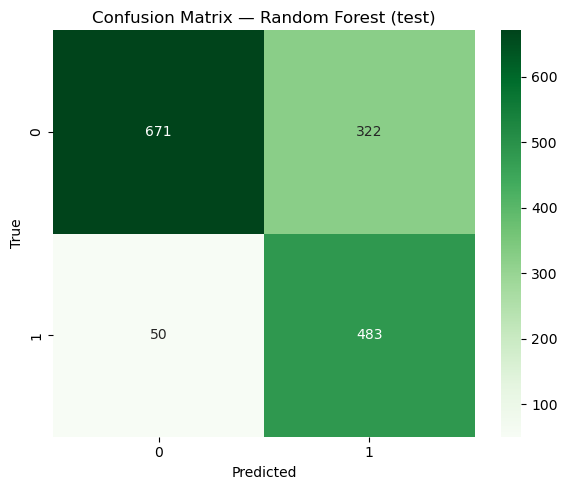

In [31]:
plot_confusion_matrix_simple(y_test, y_pred_test,
                             title="Confusion Matrix — Random Forest (test)")

# Выводы

**Моделирование:**

Проведена оценка моделей Random Forest, использующих разные методы для борьбы с дисбалансом классов. Лучший результат по метрике recall для класса 1 показала модель с даунсэмплингом. Кроме того, были проведены эксперименты по изменению порога принятия решений и генерации дополнительных признаков. Добавление новых признаков не улучшило ключевую метрику. Оптимальным значением порога вероятности является отметка в 0.35. Кроме того, проведена оценка важности признаков на основе встроенного feature importance и SHAP. Наиболее важными признаками для модели являются биохимические показатели: Bilirubin, Prothrombin и Copper.  

**Результаты:**

На тесте выбранная модель демонстрирует recall класса 1 = 0.91 и precision класса 1 = 0.6. На данный момент это лучший результат в сравнении с логистической регрессией (0.90 и 0.59 соответственно) и деревом решений (0.88 и 0.54 соответственно).